In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# reference: 
# https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
# https://github.com/yanneta/deep-learning-with-pytorch/blob/master/lesson9-muti-task-fish.ipynb

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import cv2
from PIL import Image
from tqdm import tqdm


In [4]:
# !pip install albumentations

In [5]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

### **Notes**:

- Haven't take images without bboxes into account.

- Train / valid split.

- Resize bboxes in a better way.

- Why albumentation changes int to float.

In [6]:
from pathlib import Path

path = Path("../data")
image_folder = Path("../data/train")
resize_folder = Path("../data/resize_train")

## Read data

In [7]:
# read raw train data
train = pd.read_csv(path/"train.csv")
print(train.shape)
train.head()

(147793, 5)


,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [8]:
# read clean wheat data
wheat = pd.read_csv(path/"wheat.csv")
print(wheat.shape)
wheat.head()

(147793, 5)


,image_id,xmin,ymin,xmax,ymax
0,b6ab77fd7.jpg,834.0,222.0,890.0,258.0
1,b6ab77fd7.jpg,226.0,548.0,356.0,606.0
2,b6ab77fd7.jpg,377.0,504.0,451.0,664.0
3,b6ab77fd7.jpg,834.0,95.0,943.0,202.0
4,b6ab77fd7.jpg,26.0,144.0,150.0,261.0


## Train / Valid split

- **usask_1** and **rres_1** as validation set.
- Number of images roughly 20%.

In [9]:
# carve out a validation set from 2 sources
valid_id = train.loc[train.source.isin(["usask_1", "rres_1"])].image_id.unique()
len(valid_id)

632

In [10]:
# number of training examples
train.image_id.nunique() - len(valid_id)

2741

In [11]:
valid_id = [Id+".jpg" for Id in valid_id]  # image_id of validation set

In [12]:
train_wheat = wheat.loc[~wheat.image_id.isin(valid_id)].reset_index(drop=True)
valid_wheat = wheat.loc[wheat.image_id.isin(valid_id)].reset_index(drop=True)
print("train:", train_wheat.shape, "valid:", valid_wheat.shape)

train: (121750, 5) valid: (26043, 5)


In [13]:
train_wheat.head()

,image_id,xmin,ymin,xmax,ymax
0,44c60402e.jpg,830.0,21.0,896.0,78.0
1,44c60402e.jpg,752.0,0.0,804.0,49.0
2,44c60402e.jpg,321.0,0.0,467.0,32.0
3,44c60402e.jpg,363.0,32.0,471.0,97.0
4,44c60402e.jpg,555.0,63.0,612.0,109.0


In [14]:
# train_wheat[["xmin", "ymin", "xmax", "ymax"]] = train_wheat[["xmin", "ymin", "xmax", "ymax"]] \
#                                                             .apply(lambda x: np.array(x * 224 / 1024, dtype=np.int32))
# valid_wheat[["xmin", "ymin", "xmax", "ymax"]] = valid_wheat[["xmin", "ymin", "xmax", "ymax"]] \
#                                                             .apply(lambda x: np.array(x * 224 / 1024, dtype=np.int32))

## Original images and bboxes

In [15]:
def read_image(path):
    """
    Read image from path, convert to RGB channel.
    """
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert to B G R channels

def get_im_bb(path, df):
    """
    Get single image and bbox based on path and df.
    """
    im = read_image(path)
    image_id = path.parts[-1]
    bboxes = df.loc[df.image_id == image_id, ["xmin", "ymin", "xmax", "ymax"]].values
    return im, bboxes

In [16]:
# example
p = image_folder/"44c60402e.jpg"
im, bboxes = get_im_bb(p, train_wheat)
im.shape, len(bboxes)

((1024, 1024, 3), 60)

In [17]:
def create_corner_rect(bb, color='red'):
    """
    Create a red bbox for plotting.
    """
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=2)

def show_corner_bb(im, bboxes):
    """
    Plot image with bbox.
    """
    plt.imshow(im)
    for bb in bboxes:
        plt.gca().add_patch(create_corner_rect(bb))

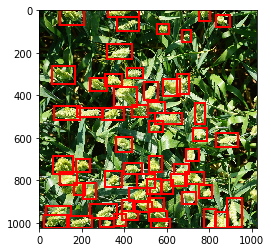

In [18]:
show_corner_bb(im, bboxes)

## Bboxes to pixels

In [19]:
def make_bb_px(y, x):
    """
    Makes an image of size x retangular bounding box.
    Represent bbox using image.
    """
    r,c,*_ = x.shape
    Y = np.zeros((r, c))
    y = y.astype(np.int)
    Y[y[1]:y[3]+1, y[0]:y[2]+1] = 1.
    return Y

def to_bb(Y):
    """
    Convert mask Y to a bounding box, assumes 0 as background nonzero object.
    Get bbox from the image representation.
    """
    rows, cols = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [20]:
Y = make_bb_px(bboxes[0], im)
print(im.shape)
print(Y.shape)
print(bboxes[0])
print(to_bb(Y))

(1024, 1024, 3)
(1024, 1024)
[830.  21. 896.  78.]
[830.  21. 896.  78.]


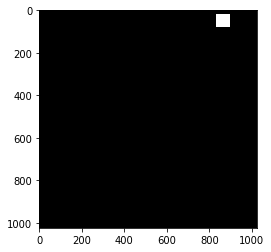

In [21]:
plt.imshow(Y, cmap='gray')

## Resizing

In [22]:
def resize_tr(im, bboxes, sz):
    """
    Resize image and bbox at the same time.
    """
    Ys = [make_bb_px(bb, im) for bb in bboxes]
    im2 = cv2.resize(im, (sz, sz))
    Y2s = [cv2.resize(Y, (sz, sz)) for Y in Ys]
    return im2, np.stack([to_bb(Y2) for Y2 in Y2s])

def resize_all_images(df, train_path, valid_path, org_path, sz=224):
    """
    Resize all images and store in folders.
    """
    tmp = df.copy()
    files = list(org_path.iterdir())  # if x.suffix == ".jpg"
    annos_id = df.image_id.values  # consider other images in the future
    
    for f in files:
        image_id = f.parts[-1]
        if image_id in annos_id:
            if image_id not in valid_id:
                new_path = train_path/image_id
            else:
                new_path = valid_path/image_id
            im, bboxes = get_im_bb(f, df)
            im, bboxes = resize_tr(im, bboxes, sz)

            cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR)) 
            tmp.loc[tmp.image_id == image_id, ["xmin", "ymin", "xmax", "ymax"]] = bboxes
    
    tmp.to_csv(path/"wheat_224.csv", index=False)

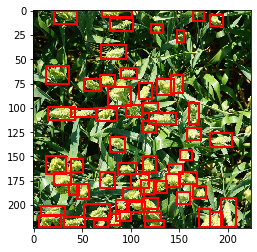

In [23]:
# example after resizing
im_r, bboxes_r = resize_tr(im, bboxes, 224)
show_corner_bb(im_r, bboxes_r)

In [24]:
# folder to store resized images
train_path = path/"train_224"
valid_path = path/"valid_224"

# train_path.mkdir(exist_ok=True)
# valid_path.mkdir(exist_ok=True)

In [25]:
# only run once
# resize_all_images(wheat, train_path, valid_path, image_folder, sz=224)

In [26]:
# read resized bboxes back
resize_wheat = pd.read_csv(path/"wheat_224.csv")
resize_wheat.head()

,image_id,xmin,ymin,xmax,ymax
0,b6ab77fd7.jpg,182.0,48.0,194.0,56.0
1,b6ab77fd7.jpg,49.0,120.0,77.0,132.0
2,b6ab77fd7.jpg,82.0,110.0,98.0,145.0
3,b6ab77fd7.jpg,182.0,21.0,206.0,44.0
4,b6ab77fd7.jpg,6.0,31.0,32.0,56.0


In [27]:
resize_wheat[["xmin", "ymin", "xmax", "ymax"]].min()

xmin    0.0
ymin    0.0
xmax    0.0
ymax    0.0
dtype: float64

### Debug

- Remove tiny bboxes.

In [28]:
# fix bugs
print(resize_wheat.shape[0])
resize_wheat = resize_wheat.loc[(resize_wheat.xmin < resize_wheat.xmax) & (resize_wheat.ymin < resize_wheat.ymax)]
print(resize_wheat.shape[0])

147793
147646


In [29]:
# new example
"b6ab77fd7.jpg" in valid_id

True

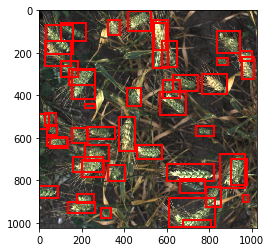

In [30]:
# before resizing
p = image_folder/"b6ab77fd7.jpg"
im, bboxes = get_im_bb(p, valid_wheat)
show_corner_bb(im, bboxes)

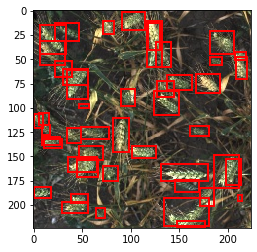

In [31]:
# after resizing
p_r = valid_path/"b6ab77fd7.jpg"
im_r, bboxes_r = get_im_bb(p_r, resize_wheat)
show_corner_bb(im_r, bboxes_r)

In [32]:
# write a test to check all images are resized

- What about images without bounding boxes?
- Bboxes normalization?
- Non-max suppression: how do you know it's the same object?
- kmeans of anchor boxes

## Dataset

- Why keep _image_ numpy array instead of tensor in dataset?
- Reduce precision of decimals, float boxes don't work.
- How to clear GPU memory?

In [33]:
class WheatDataSet(Dataset):
    def __init__(self, df, folder, transforms=None):
        self.df = df
        self.image_ids = [f.parts[-1] for f in list(folder.iterdir())]  # sample [:100]
        self.folder = folder
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # get image and boxes
        image_id = self.image_ids[idx]
        image, boxes = get_im_bb(self.folder/image_id, self.df)
        image = image.astype(np.float32) / 255.0  # normalize to 0~1
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])  # area of the bounding boxes
        
        # convert everything into tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        # compile target to return
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms:  # transform will turn bboxes into float type!
            # images augmentation
            augmented = {
                "image":image,
                "bboxes":boxes,
                "labels":labels
            }
            augmented = self.transforms(**augmented)
            
            image = augmented["image"]  # tensor of (3, 224, 224)
            target["boxes"] = torch.stack(tuple(map(torch.tensor,  # convert list of tuples back to tensor
                                                    zip(*augmented["bboxes"])))).permute(1, 0).float()  # MUST have .float()
        
        return image, target #, image_id


In [34]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )
    # bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )
    # bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}

In [35]:
train_ds = WheatDataSet(resize_wheat, train_path, get_train_transform())
valid_ds = WheatDataSet(resize_wheat, valid_path, get_valid_transform())

In [36]:
# train_ds = WheatDataSet(resize_wheat, train_path)
# valid_ds = WheatDataSet(resize_wheat, valid_path)

In [37]:
len(train_ds)

2741

In [38]:
train_ds[0]

(tensor([[[0.4235, 0.4157, 0.3922,  ..., 0.0588, 0.0706, 0.0353],
          [0.4157, 0.3843, 0.3255,  ..., 0.0667, 0.0431, 0.0157],
          [0.3922, 0.3569, 0.2941,  ..., 0.0627, 0.0078, 0.0235],
          ...,
          [0.1961, 0.2627, 0.2431,  ..., 0.5137, 0.5725, 0.5176],
          [0.1176, 0.3529, 0.3882,  ..., 0.4980, 0.5725, 0.5098],
          [0.2627, 0.1373, 0.2706,  ..., 0.5686, 0.4980, 0.5216]],
 
         [[0.4784, 0.4706, 0.4392,  ..., 0.0588, 0.0667, 0.0314],
          [0.4706, 0.4392, 0.3725,  ..., 0.0667, 0.0392, 0.0118],
          [0.4392, 0.4039, 0.3412,  ..., 0.0667, 0.0118, 0.0275],
          ...,
          [0.2353, 0.3020, 0.2941,  ..., 0.5529, 0.6235, 0.5686],
          [0.1451, 0.3882, 0.4353,  ..., 0.5333, 0.6235, 0.5686],
          [0.2863, 0.1647, 0.3176,  ..., 0.6039, 0.5529, 0.5804]],
 
         [[0.3882, 0.3804, 0.3529,  ..., 0.0275, 0.0471, 0.0118],
          [0.3804, 0.3490, 0.2863,  ..., 0.0353, 0.0196, 0.0000],
          [0.3608, 0.3255, 0.2549,  ...,

### Bug

- Tiny bboxes result in equal min max values.
- Remove these records in the resizing phase.

In [39]:
# resize_wheat.loc[resize_wheat.ymin >= resize_wheat.ymax]

In [40]:
# wheat.loc[wheat.image_id == "8b558e9e3.jpg"]
# show_corner_bb(*get_im_bb(image_folder/"8b558e9e3.jpg", wheat))

In [41]:
image, target = train_ds[0]  # "77d1f3c18.jpg"
image.shape, target["boxes"][:5]

(torch.Size([3, 224, 224]),
 tensor([[144.0000, 198.0000, 157.0000, 215.0000],
         [167.0000, 142.0000, 182.0000, 165.0000],
         [160.0000, 152.0000, 168.0000, 178.0000],
         [217.0000, 128.0000, 224.0000, 141.0000],
         [121.0000, 205.0000, 136.0000, 220.0000]]))

In [42]:
# resize_wheat.loc[resize_wheat.image_id == "77d1f3c18.jpg"][:5]

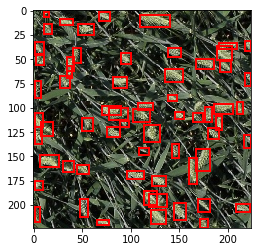

In [43]:
show_corner_bb(image.permute(1, 2, 0), target["boxes"])

**Note**:
After transforms:
- _image_ from np.array to torch.tensor
- _image_ from (224, 224, 3) to (3, 224, 224)

### Expts on transforms

In [44]:
# samp = {'image': image, 'bboxes': target['boxes'], 'labels': target["labels"]}
# samp

In [45]:
# samp_ = get_train_transform()(**samp)
# samp_

In [46]:
# before transform
# show_corner_bb(samp["image"].astype(np.int), samp["bboxes"])

In [47]:
# after transform
# show_corner_bb(samp_["image"].permute(1, 2, 0).numpy().astype(np.int), samp_["bboxes"])

## Load model

In [52]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (wheat) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [53]:
# reference: https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
# define loss metric
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
    
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0: 
            return 0
        else:
            return self.current_total / self.iterations  # 1.0 *
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [54]:
# customize batch?
def collate_fn(batch):
    return tuple(zip(*batch))  # pack image & target into a tuple

In [46]:
train_dl = DataLoader(train_ds, batch_size=2, collate_fn=collate_fn, shuffle=True, num_workers=4)  
valid_dl = DataLoader(valid_ds, batch_size=2, collate_fn=collate_fn, num_workers=4)

In [49]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [50]:
# example
images, targets = next(iter(train_dl))

# cuda for training
images = list(image.cuda() for image in images)
targets = [{k:v.cuda() for k, v in t.items()} for t in targets]

In [51]:
images[0].shape

torch.Size([3, 224, 224])

In [52]:
# images[0], targets[0]

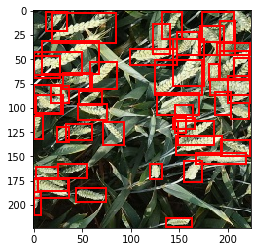

In [53]:
# example after augmentation
bboxes_a = targets[0]["boxes"].cpu().detach().numpy()  #.astype(np.int32)
im_a = images[0].permute(1, 2, 0).cpu().detach().numpy()  #.astype(np.int32)

show_corner_bb(im_a, bboxes_a)

In [54]:
# model.cuda()

In [55]:
# model(images, targets)

### Train model

In [55]:
def train_epocs(model, optimizer, train_dl, valid_dl, epochs=10):
    loss_hist = Averager()
    for i in range(epochs):
        model.train()
        loss_hist.reset()
        for images, targets in train_dl:
            images = list(image.cuda() for image in images)
            targets = [{k:v.cuda() for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            loss_hist.send(loss_value)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # val_loss, val_acc = val_metrics(model, valid_dl)
        # if i % 5 == 1:
        # print("train loss %.3f val loss %.3f and val accuracy %.3f" % (loss_hist.value, val_loss, val_acc))
        print("train loss %.3f" % loss_hist.value)

In [57]:
# def val_metrics(model, valid_dl):
#     model.eval()
#     correct = 0
#     total = 0
#     sum_loss = 0.0
#     for x, s, y in valid_dl:
#         x = x.long().cuda()
#         y = y.float().unsqueeze(1).cuda()
#         y_hat = model(x, s)
#         loss = F.binary_cross_entropy_with_logits(y_hat, y)
#         y_pred = y_hat > 0
#         correct += (y_pred.float() == y).float().sum()
#         total += y.shape[0]
#         sum_loss += loss.item()*y.shape[0]
#     return sum_loss/total, correct/total

In [56]:
model.cuda()

parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001, weight_decay=0.0005)

# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [57]:
batch_size = 8
train_dl = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=4)  
valid_dl = DataLoader(valid_ds, batch_size=batch_size, collate_fn=collate_fn, num_workers=4)

In [58]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=2)

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


RuntimeError: CUDA out of memory. Tried to allocate 314.00 MiB (GPU 0; 11.17 GiB total capacity; 537.42 MiB already allocated; 169.94 MiB free; 550.00 MiB reserved in total by PyTorch)

## Prediction

In [64]:
images, targets = next(iter(valid_dl))

images = [image.cuda() for image in images]
targets = [{k:v.cuda() for k, v in t.items()} for t in targets]

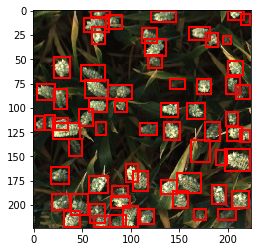

In [65]:
# original
bboxes = targets[0]["boxes"].cpu().detach().numpy()  #.astype(np.int32)
im = images[0].permute(1, 2, 0).cpu().detach().numpy()  #.astype(np.int32)

show_corner_bb(im, bboxes)

In [67]:
len(images)

8

In [69]:
images[0]

tensor([[[0.0980, 0.1059, 0.1333,  ..., 0.0980, 0.1294, 0.1216],
         [0.1529, 0.1569, 0.1686,  ..., 0.0941, 0.1059, 0.0863],
         [0.1490, 0.1529, 0.1569,  ..., 0.0902, 0.1020, 0.0863],
         ...,
         [0.0863, 0.0588, 0.0824,  ..., 0.3333, 0.3176, 0.3255],
         [0.0941, 0.0863, 0.0980,  ..., 0.3765, 0.3451, 0.3333],
         [0.2196, 0.0941, 0.0863,  ..., 0.3647, 0.3412, 0.3412]],

        [[0.1529, 0.1608, 0.1804,  ..., 0.0941, 0.1137, 0.1059],
         [0.2039, 0.2118, 0.2235,  ..., 0.0902, 0.0902, 0.0706],
         [0.2078, 0.2118, 0.2196,  ..., 0.0941, 0.0980, 0.0824],
         ...,
         [0.1137, 0.0863, 0.1059,  ..., 0.2549, 0.2353, 0.2431],
         [0.1059, 0.0980, 0.1098,  ..., 0.2824, 0.2431, 0.2314],
         [0.2275, 0.1020, 0.0980,  ..., 0.2706, 0.2314, 0.2353]],

        [[0.0627, 0.0627, 0.0863,  ..., 0.0784, 0.1020, 0.0941],
         [0.1255, 0.1216, 0.1216,  ..., 0.0745, 0.0784, 0.0588],
         [0.1333, 0.1216, 0.1137,  ..., 0.0745, 0.0784, 0.

In [68]:
model.eval()
outputs = model(images)
outputs = [{k:v.cpu() for k, v in t.items()} for t in outputs]

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

In [76]:
torch.cuda.empty_cache()

In [49]:
torch.cuda.get_device_properties(0).total_memory

11996954624

In [59]:
torch.cuda.memory_cached(0)

576716800

In [53]:
torch.cuda.memory_allocated(0)

563525120